### 1. Introduction

# Dataset
### Diabetes : https://www.kaggle.com/datasets/uciml/pima-indians-diabetes-database?resource=download
## Penjelasan Atribut Dataset
- Pregnancies               : Untuk menyatakan Jumlah kehamilan
- Glucose                   : Tingkat Glukosa dalam darah 2 jam dalam tes toleransi glukosa oral
- BMI                       : Indeks massa tubuh (berat badan dalam kg/(tinggi dalam m)^2)
- Age                       : Umur (tahun)
- DiabetesPedigreeFunction  : Presentase keturunan diabetes
- BloodPressure             : Tekanan darah diastolik (mm Hg)
- SkinThickness             : Ketebalan lipatan kulit pada triceps (mm)
- insulin                   : Tingkat insulin dalam darah 

- Outcome                   : Menyatakan hasil akhir 1 adalah Ya (terkena diabetes) dan 0 adalah Tidak (tidak terkena diabetes)


### 2. Data Undestanding

2.1 Import Library

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from pymongo import MongoClient
from imblearn.over_sampling import SMOTE
import joblib

from sklearn.impute import KNNImputer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

2.2 Read Dataset

In [2]:
diabetes_dataset = pd.read_csv('diabetes.csv')
diabetes_dataset.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


2.3 Insert Dataset ke MongoDB

In [3]:
client = MongoClient("mongodb://localhost:27017/")
db = client["prediksi_diabetes"]             
collection = db["data_diabetes"]

2.4 convert t dictionary and insert to mongodb

In [4]:
data_dict = diabetes_dataset.to_dict("records")
collection.insert_many(data_dict)
print(f"Inserted {len(data_dict)} records into MongoDB.")

Inserted 768 records into MongoDB.


2.5 Load Dataset dari MongoDB

In [5]:
# Ambil kembali data dari MongoDB
data = pd.DataFrame(list(collection.find()))

# Drop kolom _id jika ada
if '_id' in data.columns:
    data.drop('_id', axis=1, inplace=True)

data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


### 3. Data Understanding

In [6]:
# Ukuran dataset
print("\n=== Ukuran Dataset ===")
print("Jumlah baris dan kolom:", diabetes_dataset.shape)

# Info tipe data
print("\n=== Info Dataset ===")
print(diabetes_dataset.info())

# Tipe data per kolom
print("\n=== Tipe Data per Kolom ===")
print(diabetes_dataset.dtypes)

# Cek missing values
print("\n=== Missing Values ===")
print(diabetes_dataset.isnull().sum())

# Cek duplikasi
print("\n=== Cek Duplikasi ===")
print("Jumlah duplikat:", diabetes_dataset.duplicated().sum())


=== Ukuran Dataset ===
Jumlah baris dan kolom: (768, 9)

=== Info Dataset ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB
None

=== Tipe Data per Kolom ===
Pregnancies                   int64
Glucose                       int64
BloodPressure                 int64
SkinThickness      

In [7]:
# Statistik deskriptif
print("\n=== Statistik Deskriptif ===")
print(diabetes_dataset.describe(include='all').to_string()) 


=== Statistik Deskriptif ===
       Pregnancies     Glucose  BloodPressure  SkinThickness     Insulin         BMI  DiabetesPedigreeFunction         Age     Outcome
count   768.000000  768.000000     768.000000     768.000000  768.000000  768.000000                768.000000  768.000000  768.000000
mean      3.845052  120.894531      69.105469      20.536458   79.799479   31.992578                  0.471876   33.240885    0.348958
std       3.369578   31.972618      19.355807      15.952218  115.244002    7.884160                  0.331329   11.760232    0.476951
min       0.000000    0.000000       0.000000       0.000000    0.000000    0.000000                  0.078000   21.000000    0.000000
25%       1.000000   99.000000      62.000000       0.000000    0.000000   27.300000                  0.243750   24.000000    0.000000
50%       3.000000  117.000000      72.000000      23.000000   30.500000   32.000000                  0.372500   29.000000    0.000000
75%       6.000000  140.2

In [8]:
# Cek missing values
print("\n=== Missing Values ===")
print(diabetes_dataset.isnull().sum())


=== Missing Values ===
Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64


In [9]:
diabetes_dataset['Outcome'].value_counts()

Outcome
0    500
1    268
Name: count, dtype: int64

## 4. Exploratory Data Analysis (EDA)

# 1. Analisis Univariate

Analisis univariat dilakukan untuk memahami distribusi masing-masing variabel secara individu.

<Figure size 1200x800 with 0 Axes>

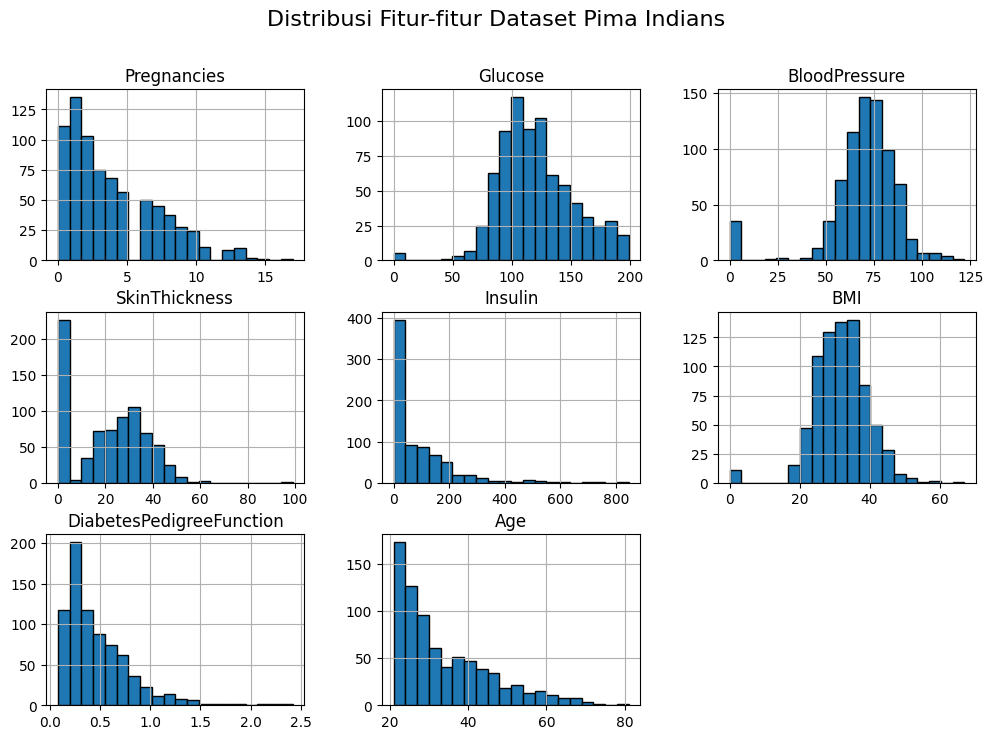

In [10]:
# 1. Visualisasi distribusi fitur numerik
plt.figure(figsize=(12, 8))
diabetes_dataset.drop('Outcome', axis=1).hist(bins=20, edgecolor='black', figsize=(12, 8))
plt.suptitle("Distribusi Fitur-fitur Dataset Pima Indians", fontsize=16)
plt.show()

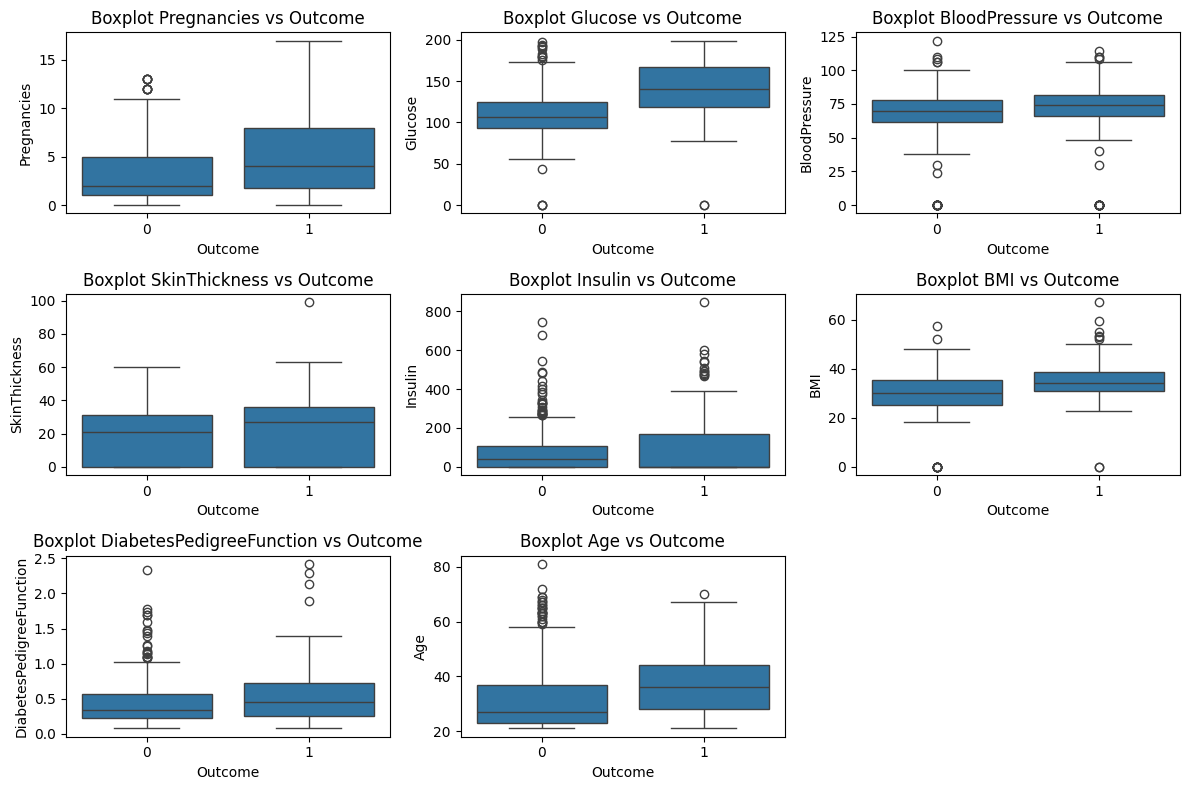

In [11]:
# 3. Boxplot untuk visualisasi pencilan
plt.figure(figsize=(12, 8))
for i, feature in enumerate(diabetes_dataset.drop('Outcome', axis=1).columns):
    plt.subplot(3, 3, i+1)
    sns.boxplot(x='Outcome', y=feature, data=diabetes_dataset)
    plt.title(f'Boxplot {feature} vs Outcome')
plt.tight_layout()
plt.show()

C:\Users\Mega Global\AppData\Local\Temp\ipykernel_12052\984233593.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  a = sns.countplot(x='Outcome', data=data, palette='Set2')


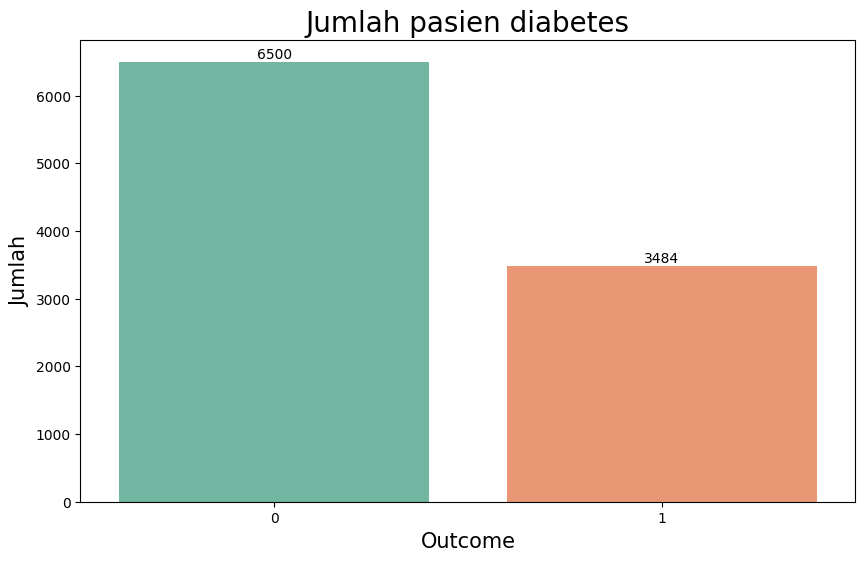

In [12]:
# Distribusi Variabel Target (Outcome)
plt.figure(figsize=(10,6))
a = sns.countplot(x='Outcome', data=data, palette='Set2')
for j in a.containers:
    a.bar_label(j, label_type='edge')
plt.title('Jumlah pasien diabetes', fontsize=20)
plt.xlabel('Outcome', fontsize=15)
plt.ylabel('Jumlah', fontsize=15)
plt.show()

Data yang disajikan menggambarkan bahwa terdapat 268 orang yang mengalami diabetes, sedangkan sebanyak 500 orang tidak mengalami kondisi diabetes.

# 2. Analisis Bivariate

Analisis bivariat dilakukan untuk melihat hubungan dua variabel, misalnya antara Outcome dan variabel lain.

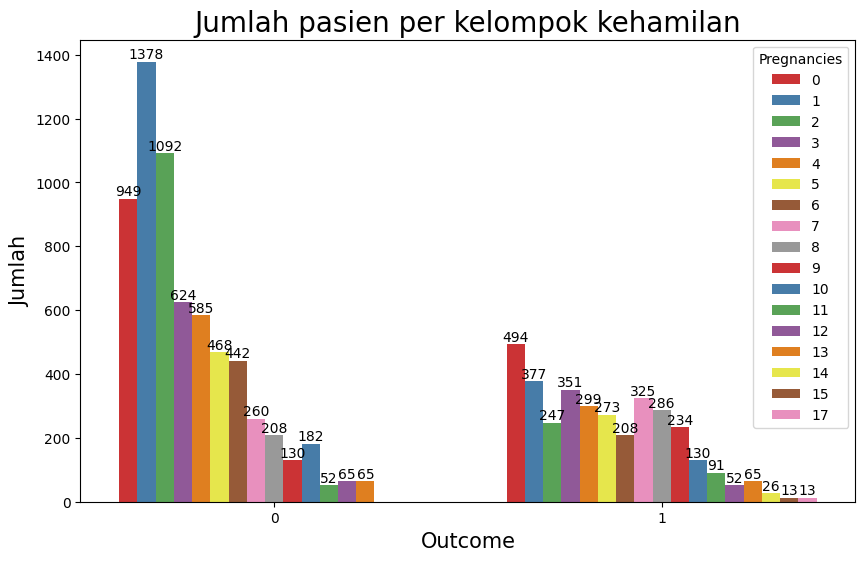

In [13]:
plt.figure(figsize=(10,6))
a = sns.countplot(x='Outcome', hue='Pregnancies', data=data, palette='Set1')
for j in a.containers:
    a.bar_label(j, label_type='edge')
plt.title('Jumlah pasien per kelompok kehamilan', fontsize=20)
plt.xlabel('Outcome', fontsize=15)
plt.ylabel('Jumlah', fontsize=15)
plt.show() 

Jumlah pasien perkelompok kehamilan yang paling banyak terkena diabets adalah 0 kehamilan dengan jumlah 38 orang lalu diikuti dengan 3 kehamilan dengan jumlah 27 orang dan yang paling sedikit adalah 17 kehamilan dengan jumlah 1 orang.

# 3. Analisis Multivariate

Analisis multivariat melihat hubungan lebih dari dua variabel.

In [14]:
# Menambahkan kolom kelompok umur
age_grup = []
for i in data['Age']:
    if i >= 17 and i <= 25:
        age_grup.append('Remaja Akhir')
    elif i >= 26 and i <= 35:
        age_grup.append('Dewasa Awal')
    elif i >= 36 and i <= 45:
        age_grup.append('Dewasa Akhir')
    elif i >= 46 and i <= 55:
        age_grup.append('Lansia Awal')
    elif i >= 56 and i <= 65:
        age_grup.append('Lansia Akhir')
    else:
        age_grup.append('Manula')
data['Age_grup'] = age_grup

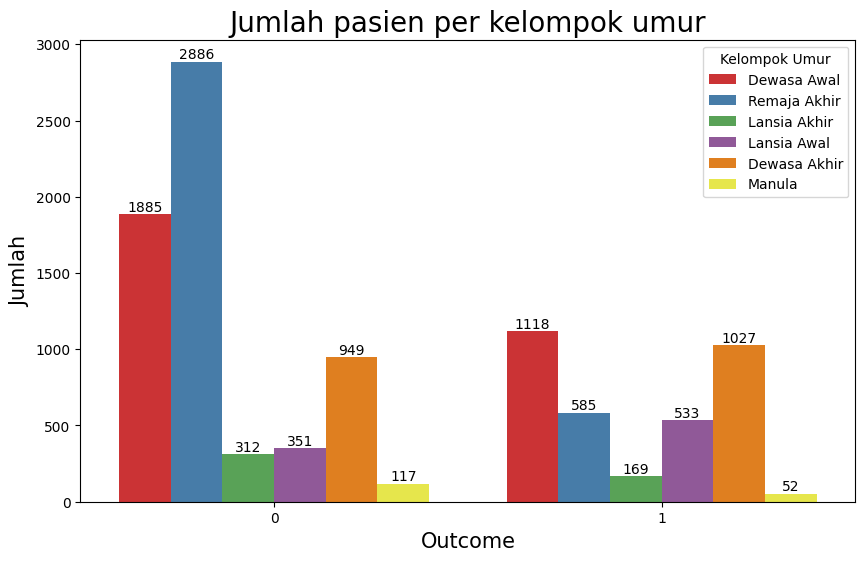

In [15]:
plt.figure(figsize=(10,6))
a = sns.countplot(x='Outcome', hue='Age_grup', data=data, palette='Set1')
for j in a.containers:
    a.bar_label(j, label_type='edge')
plt.title('Jumlah pasien per kelompok umur', fontsize=20)
plt.xlabel('Outcome', fontsize=15)
plt.ylabel('Jumlah', fontsize=15) 
plt.legend(loc='upper right', title='Kelompok Umur')  
plt.show() 

In [16]:
data[['Outcome', 'Age_grup']].value_counts()

Outcome  Age_grup    
0        Remaja Akhir    2886
         Dewasa Awal     1885
1        Dewasa Awal     1118
         Dewasa Akhir    1027
0        Dewasa Akhir     949
1        Remaja Akhir     585
         Lansia Awal      533
0        Lansia Awal      351
         Lansia Akhir     312
1        Lansia Akhir     169
0        Manula           117
1        Manula            52
Name: count, dtype: int64

Banyak pasien yang terkena diabetes adalah yang berumur 26-35 tahun atau dewasa awal dengan jumlah 86 orang lalu diikutu dengan dewasa akhir yaitu 46-55 tahun dengan jumlah 79 orang dan yang paling sedikit adalah manula dengan jumlah 4 orang.

In [17]:
BMI_grup = []
for i in data['BMI']:
    if i >= 0 and i <= 18.5:
        BMI_grup.append('Kurus')
    elif i >= 18.6 and i <= 22.9:
        BMI_grup.append('Normal')
    elif i >= 23 and i <= 24.9:
        BMI_grup.append('Gemuk')
    elif i >= 25 and i <= 29.9:
        BMI_grup.append('Obesitas')
    else:
        BMI_grup.append('Obesitas II')            

In [18]:
data['BMI_grup'] = BMI_grup
data

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,Age_grup,BMI_grup
0,6,148,72,35,0,33.6,0.627,50,1,Lansia Awal,Obesitas II
1,1,85,66,29,0,26.6,0.351,31,0,Dewasa Awal,Obesitas
2,8,183,64,0,0,23.3,0.672,32,1,Dewasa Awal,Gemuk
3,1,89,66,23,94,28.1,0.167,21,0,Remaja Akhir,Obesitas
4,0,137,40,35,168,43.1,2.288,33,1,Dewasa Awal,Obesitas II
...,...,...,...,...,...,...,...,...,...,...,...
9979,10,101,76,48,180,32.9,0.171,63,0,Lansia Akhir,Obesitas II
9980,2,122,70,27,0,36.8,0.340,27,0,Dewasa Awal,Obesitas II
9981,5,121,72,23,112,26.2,0.245,30,0,Dewasa Awal,Obesitas
9982,1,126,60,0,0,30.1,0.349,47,1,Lansia Awal,Obesitas II


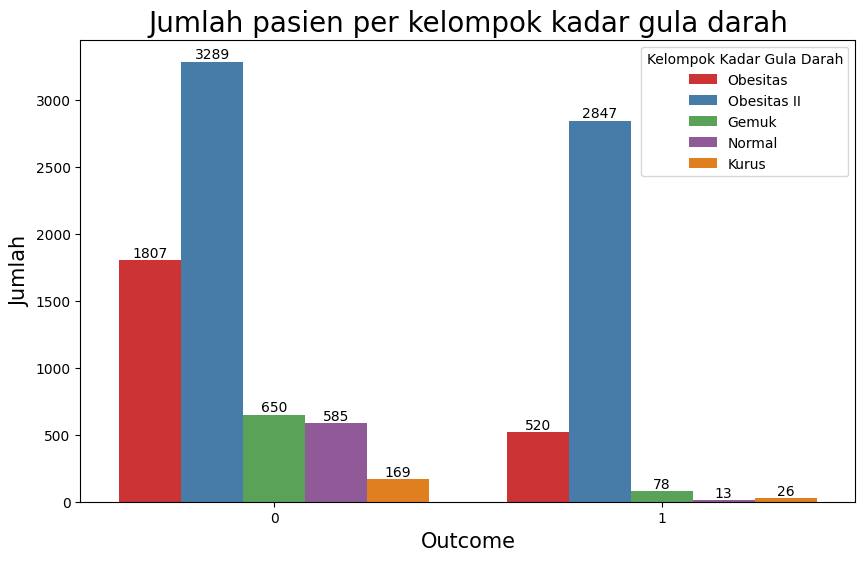

In [19]:
plt.figure(figsize=(10,6))
a = sns.countplot(x='Outcome', hue='BMI_grup', data=data, palette='Set1')
for j in a.containers:
    a.bar_label(j, label_type='edge')
plt.title('Jumlah pasien per kelompok kadar gula darah', fontsize=20)
plt.xlabel('Outcome', fontsize=15)
plt.ylabel('Jumlah', fontsize=15)
plt.legend(loc='upper right', title='Kelompok Kadar Gula Darah')
plt.show()    

In [20]:
data[['Outcome', 'BMI_grup']].value_counts()

Outcome  BMI_grup   
0        Obesitas II    3289
1        Obesitas II    2847
0        Obesitas       1807
         Gemuk           650
         Normal          585
1        Obesitas        520
0        Kurus           169
1        Gemuk            78
         Kurus            26
         Normal           13
Name: count, dtype: int64

Berdasarkan kelompok BMI yang paling banyak terkena diabetes adalah yang memiliki BMI lebih dari 30 (Obesitasa II) dengan jumlah 219 orang lalu diikuti dengan BMI 25 - 29.9 (Obesitas) dengan jumlah 40 orang.

In [21]:
data = data.drop(columns=['Age_grup', 'BMI_grup'])
print(data.columns)

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')


In [22]:
print(data.columns)
print(data.isnull().sum())
data = data.drop_duplicates()

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')
Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64


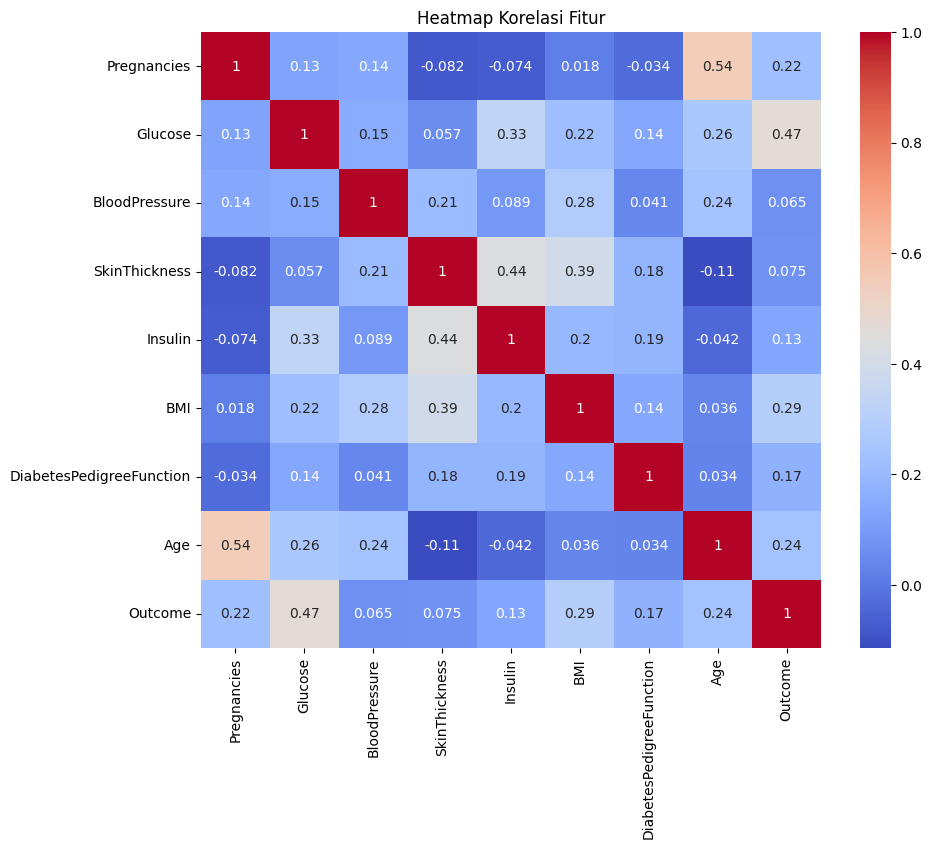

In [23]:
corr = data.corr()

plt.figure(figsize=(10, 8)) 
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Heatmap Korelasi Fitur")
plt.show()

### 4. Data Cleaning

4.1 Tangani Missing Values

In [24]:
# Kolom yang tidak boleh punya nilai 0
invalid_zero_cols = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

# Ganti nilai 0 menjadi NaN
data[invalid_zero_cols] = data[invalid_zero_cols].replace(0, np.nan)

# Cek jumlah missing values
print("Missing values setelah diganti:")
print(data.isnull().sum())

Missing values setelah diganti:
Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64


4.2 Hapus Kolom dengan Banyak Missing dan Korelasi Rendah

In [25]:
data.drop(['Insulin', 'SkinThickness', 'DiabetesPedigreeFunction'], axis=1, inplace=True)

Kolom Insulin dan SkinThickness memiliki lebih dari 30-40% nilai kosong (0 sebelumnya), serta korelasi rendah dengan Outcome. Maka, kita hapus, Kolom DiabetesPedigreeFunction juga memiliki korelasi rendah dengan Outcome dan sulit diukur langsung secara medis,

In [26]:
print(data.columns)

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'BMI', 'Age', 'Outcome'], dtype='object')


4.3 Imputasi Missing Values untuk Kolom Penting

In [27]:
from sklearn.impute import KNNImputer
# Pisahkan fitur dan target
X_temp = data.drop(columns='Outcome')
y_temp = data['Outcome']

# imputasi
imputer = KNNImputer(n_neighbors=5)
X_imputed = imputer.fit_transform(X_temp)

# Buat ulang DataFrame
columns = X_temp.columns
data_imputed = pd.DataFrame(X_imputed, columns=columns)
data_imputed['Outcome'] = y_temp

# Simpan hasil imputasi ke variabel akhir
data = data_imputed

# Cek missing
print("Cek missing setelah imputasi:")
print(data.isnull().sum())

Cek missing setelah imputasi:
Pregnancies      0
Glucose          0
BloodPressure    0
BMI              0
Age              0
Outcome          0
dtype: int64


4.4 Tangani Duplikasi

In [28]:
print("Jumlah data sebelum drop duplikat:", data.shape[0])
data.drop_duplicates(inplace=True)
print("Jumlah data setelah drop duplikat:", data.shape[0])

Jumlah data sebelum drop duplikat: 768
Jumlah data setelah drop duplikat: 768


4.5 Feature Enginering

In [29]:
# Buat fitur baru
data['Glucose_BMI'] = data['Glucose'] * data['BMI']
data['Age_BMI'] = data['Age'] * data['BMI']
data['BP_Age'] = data['BloodPressure'] / (data['Age'] + 1)

# Buat kategori BMI  
data['BMI_Category'] = pd.cut(data['BMI'], 
                               bins=[0, 18.5, 25, 30, 100], 
                               labels=[0, 1, 2, 3]).astype(int)


- orang dengan glukosa tinggi dan BMI tinggi biasanya lebih berisiko diabetes.
- Semakin tua dan semakin berat badan, risiko diabetes semakin tinggi

4.5 Tangani Outlier 

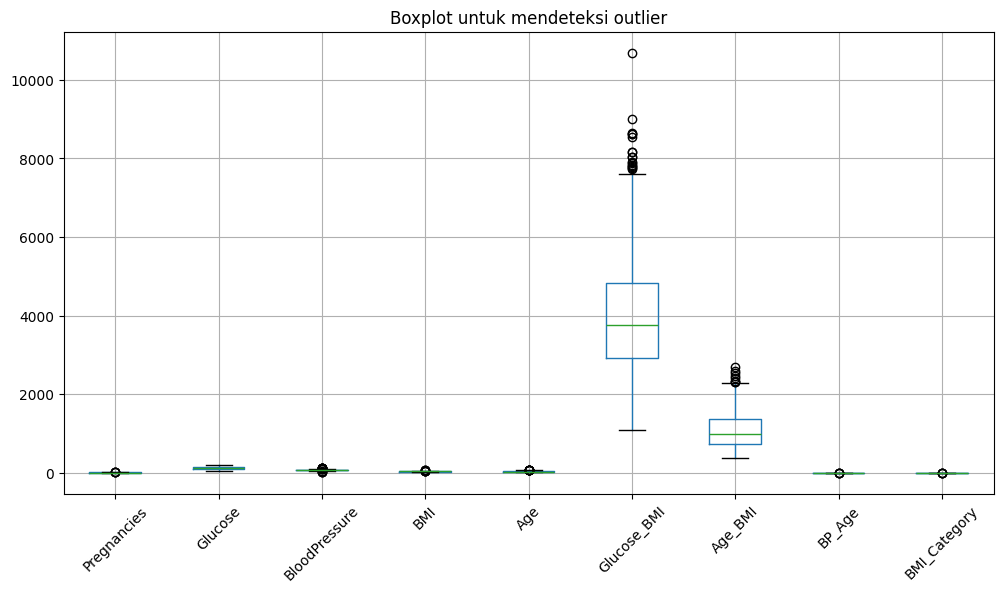

In [30]:
# Visualisasi boxplot semua fitur numerik
plt.figure(figsize=(12,6))
data.drop('Outcome', axis=1).boxplot()
plt.title("Boxplot untuk mendeteksi outlier")
plt.xticks(rotation=45)
plt.show()

In [31]:
def winsorize_outliers(df, cols, lower_percentile=0.05, upper_percentile=0.95):
    for col in cols:
        lower_bound = df[col].quantile(lower_percentile)
        upper_bound = df[col].quantile(upper_percentile)
        df[col] = np.where(df[col] < lower_bound, lower_bound, df[col])
        df[col] = np.where(df[col] > upper_bound, upper_bound, df[col])
    return df

numerical_cols = [col for col in data.select_dtypes(include=['float64', 'int64']).columns 
                  if col not in ['Outcome', 'BMI_Category']]
data = winsorize_outliers(data, numerical_cols)
print("Shape data setelah winsorizing:", data.shape)

Shape data setelah winsorizing: (768, 10)


# 5. Data Transformation

5.1 Persiapan Data

In [32]:
X = data.drop(['Outcome'], axis=1)
y = data['Outcome']

In [33]:
# Visualisasi distribusi target awal
print("Distribusi kelas awal:")
print(y.value_counts())

Distribusi kelas awal:
Outcome
0    500
1    268
Name: count, dtype: int64


In [34]:
# 2. Pemisahan data menjadi train dan test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [35]:
# Melihat distribusi kelas pada data training
print("\nDistribusi kelas pada data training:")
print(pd.Series(y_train).value_counts())


Distribusi kelas pada data training:
Outcome
0    401
1    213
Name: count, dtype: int64


In [36]:
# 3. Normalisasi data dengan benar
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
# Fitting scaler HANYA pada data training
X_train_scaled = scaler.fit_transform(X_train)
# Transform data test menggunakan parameter yang sama
X_test_scaled = scaler.transform(X_test)

In [37]:
# 4. SMOTE pada data training SETELAH train-test split
from imblearn.over_sampling import SMOTE
from collections import Counter
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

print("\nDistribusi kelas setelah SMOTE (hanya pada data training):")
print(sorted(Counter(y_train_resampled).items()))


Distribusi kelas setelah SMOTE (hanya pada data training):
[(0, 401), (1, 401)]


C:\Users\Mega Global\AppData\Local\Temp\ipykernel_12052\3468694882.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  a = sns.countplot(x='Outcome', data=data, palette='Set2', ax=ax[0])
C:\Users\Mega Global\AppData\Local\Temp\ipykernel_12052\3468694882.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  a = sns.countplot(x=y_series, palette='Set2', ax=ax[1])


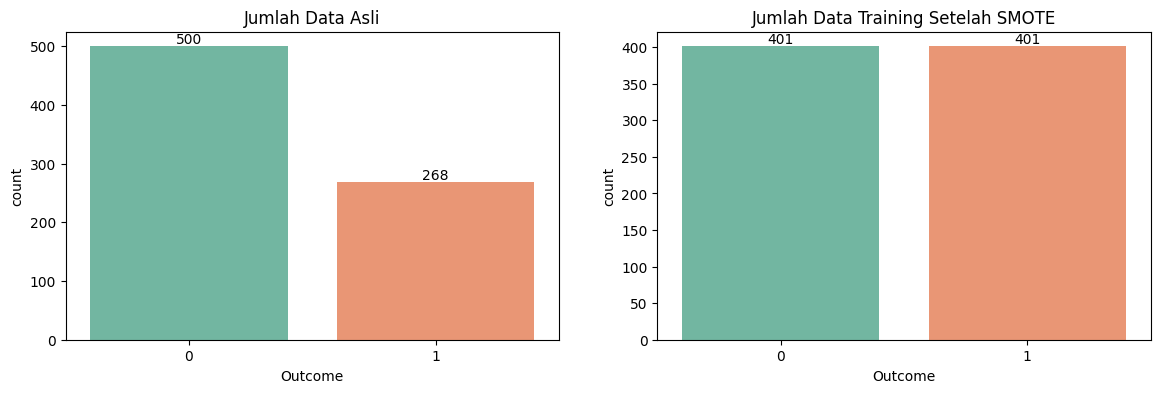

In [38]:
fig, ax = plt.subplots(1, 2, figsize=(14, 4))
# Data asli
a = sns.countplot(x='Outcome', data=data, palette='Set2', ax=ax[0])
for j in a.containers:
    a.bar_label(j, label_type='edge')
ax[0].set_title('Jumlah Data Asli')

# Data training setelah SMOTE
y_series = pd.Series(y_train_resampled, name='Outcome')
a = sns.countplot(x=y_series, palette='Set2', ax=ax[1])
for j in a.containers:
    a.bar_label(j, label_type='edge')
ax[1].set_title('Jumlah Data Training Setelah SMOTE')
plt.show()

In [39]:
# Informasi ukuran data
print('\nTotal data asli X:', len(X))
print('Total data asli y:', len(y))
print('=====================================')
print('Total data X_train awal:', len(X_train))
print('Total data y_train awal:', len(y_train))
print('Total data X_train setelah SMOTE:', len(X_train_resampled))
print('Total data y_train setelah SMOTE:', len(y_train_resampled))
print('=====================================')
print('Total data X_test:', len(X_test))
print('Total data y_test:', len(y_test))


Total data asli X: 768
Total data asli y: 768
Total data X_train awal: 614
Total data y_train awal: 614
Total data X_train setelah SMOTE: 802
Total data y_train setelah SMOTE: 802
Total data X_test: 154
Total data y_test: 154


In [40]:
models = {
    "Logistic Regression": LogisticRegression(random_state=42, solver='liblinear'),
    "SVM": SVC(kernel='linear', random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "AdaBoost": AdaBoostClassifier(random_state=42),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Gaussian Naive Bayes": GaussianNB()
}

results = {}
for name, model in models.items():
    # Training menggunakan data training yang sudah di-SMOTE
    model.fit(X_train_resampled, y_train_resampled)
    # Evaluasi menggunakan data testing yang HANYA di-scaled (tanpa SMOTE)
    y_pred = model.predict(X_test_scaled)
    accuracy = accuracy_score(y_test, y_pred)
    results[name] = accuracy

print("\nHasil Evaluasi Model:")
for name, accuracy in results.items():
    print(f"{name}: Accuracy = {accuracy:.4f}")

best_model_name = max(results, key=results.get)
print(f"\nModel Terbaik Berdasarkan Akurasi: {best_model_name} (Accuracy = {results[best_model_name]:.4f})")


Hasil Evaluasi Model:
Logistic Regression: Accuracy = 0.7078
SVM: Accuracy = 0.7208
Decision Tree: Accuracy = 0.7338
Random Forest: Accuracy = 0.7532
Gradient Boosting: Accuracy = 0.7597
AdaBoost: Accuracy = 0.7143
K-Nearest Neighbors: Accuracy = 0.7597
Gaussian Naive Bayes: Accuracy = 0.6623

Model Terbaik Berdasarkan Akurasi: Gradient Boosting (Accuracy = 0.7597)


In [41]:
# 6. Hyperparameter tuning untuk model terbaik (diasumsikan Random Forest)
from sklearn.model_selection import GridSearchCV

In [42]:
# Tuning hyperparameter untuk Random Forest
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
    'class_weight': [None, 'balanced']
}

grid_search = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

In [43]:
# GridSearchCV pada data training yang sudah di-SMOTE
grid_search.fit(X_train_resampled, y_train_resampled)
print("\nBest Parameters:", grid_search.best_params_)
print("Best CV Score:", grid_search.best_score_)

# Mengambil model terbaik dari hasil grid search
best_rf = grid_search.best_estimator_

Fitting 5 folds for each of 432 candidates, totalling 2160 fits



Best Parameters: {'class_weight': None, 'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 300}
Best CV Score: 0.8292624223602484


In [44]:
best_rf.fit(X_train_resampled, y_train_resampled)

RandomForestClassifier(max_depth=15, min_samples_leaf=2, n_estimators=300,
                       random_state=42)

In [45]:
# 7. Final evaluation dengan model terbaik
y_test_pred = best_rf.predict(X_test_scaled)  # Prediksi pada data test yang hanya di-scale
y_train_pred = best_rf.predict(X_train_resampled)  # Prediksi pada data training yang di-SMOTE

print("\nFinal Evaluation:")
print(f"Training Accuracy: {accuracy_score(y_train_resampled, y_train_pred):.4f}")
print(f"Testing Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")
print("\nClassification Report (Test Data):")
print(classification_report(y_test, y_test_pred))
print("\nConfusion Matrix (Test Data):")
print(confusion_matrix(y_test, y_test_pred))



Final Evaluation:
Training Accuracy: 0.9800
Testing Accuracy: 0.7727

Classification Report (Test Data):
              precision    recall  f1-score   support

           0       0.86      0.78      0.81        99
           1       0.66      0.76      0.71        55

    accuracy                           0.77       154
   macro avg       0.76      0.77      0.76       154
weighted avg       0.78      0.77      0.78       154


Confusion Matrix (Test Data):
[[77 22]
 [13 42]]


In [46]:
# 8. Evaluasi tambahan untuk imbalanced data
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, precision_recall_curve, auc
if hasattr(best_rf, "predict_proba"):
    y_prob = best_rf.predict_proba(X_test_scaled)[:, 1]
    roc_auc = roc_auc_score(y_test, y_prob)
    print(f"\nROC AUC Score: {roc_auc:.4f}")


ROC AUC Score: 0.8399


In [47]:
# Simpan model dan scaler
joblib.dump(best_rf, 'best_random_forest_model.pkl')

['best_random_forest_model.pkl']

In [48]:
# Load model dan scaler
classifier = joblib.load('random_forest_model.pkl')
scaler = joblib.load('scaler.pkl')

# Data input pasien
input_data = (6, 148, 72, 33.6, 50)
feature_names = ['Pregnancies', 'Glucose', 'BloodPressure', 'BMI', 'Age']

# Buat DataFrame agar sesuai dengan fitur saat scaler dilatih
input_df = pd.DataFrame([input_data], columns=feature_names)

# Scaling dan prediksi
input_scaled = scaler.transform(input_df)
prediction = classifier.predict(input_scaled)

print(f"Prediksi: {prediction[0]}")

if prediction[0] == 0:
    print('✅ Pasien tidak terkena diabetes')
else:
    print('⚠️ Pasien terkena diabetes')

c:\Users\Mega Global\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.5.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\Mega Global\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\base.py:380: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.5.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\Mega Global\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\base.py:380: InconsistentVersionW

Prediksi: 1
⚠️ Pasien terkena diabetes


In [49]:
# Data input pasien
input_data = (1, 85, 66, 26.6, 30)  
feature_names = ['Pregnancies', 'Glucose', 'BloodPressure', 'BMI', 'Age']

# Buat DataFrame agar sesuai dengan fitur saat scaler dilatih
input_df = pd.DataFrame([input_data], columns=feature_names)

# Scaling dan prediksi
input_scaled = scaler.transform(input_df)
prediction = classifier.predict(input_scaled)

# Output prediksi
print(f"Prediksi: {prediction[0]}")

if prediction[0] == 0:
    print('✅ Pasien tidak terkena diabetes')
else:
    print('⚠️ Pasien terkena diabetes')

Prediksi: 0
✅ Pasien tidak terkena diabetes
